# Mars: Electron Paramagnetic Resonacne simulation library

Mars is a powerful Python library built on PyTorch for simulating spin systems and calculating electron paramagnetic resonance (EPR) spectra. 

This notebook provides a comprehensive guide to using Mars for modeling stationary EPR spectra of various spin systems, from simple electron pairs to complex multi-spin systems with nuclei.


\
\
\
\
\
\
For any questions, please contact Arkady Samsonenko via: \
Telegram: @Arkady_Samsonenko \
Email: a.samsonenko.tomo.nsc.ru

In [1]:
import sys
import os
import math
from importlib import reload

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

import mars
from mars import spin_system, spectra_manager, mesher, save_procedures, constants

# 1. Fundamental Concepts


### 1.1 Spin Systems and Interactions


In quantum mechanincs, spin systems consist of particles (electrons, nuclei) characterized by their spin quantum numbers and interactions between them. Mars represents these systems through several core components:

**Particles**: Electrons and nuclei with defined spin values \
**Interactions**: Couplings between particles (Zeeman, dipolar, exchange, hyperfine) \
**Tensor propertie**s: Physical properties described by tensors (g-tensors, D-tensors) \
**Sample environment**: Orientation distributions, broadening parameters

*The computational workflow in Mars follows these steps:*

-Define particles (electrons, nuclei) \
-Create interactions between particles \
-Assemble the spin system \
-Configure the sample environment \
-Calculate and visualize spectra

### 1.2 Basic Interaction Types

Mars supports two primary interaction classes:

1) **Interaction**: General tensor interaction with principal values that can be: \
Isotropic (single value) \
Axial (two values: perpendicular and parallel) \
Orthorhombic (three values for x, y, z directions)

2) **DEInteraction**: Specialized for zero-field splitting interactions, parameterized by D and E values: \
D: Axial component \
E: Rhombic component

For any interaction it is possible to set: \ 
Frame to ratate this interaction via 3 euler angles or 3 x 3 rotation matrix \
Strains, which define the broadaning of a spectra due distribution of Spin Hamiltonian parameters 



Let's create interaction between two electrons

In [2]:
exchange_interaction = spin_system.Interaction(
    constants.unit_converter(1.0, "cm-1_to_Hz")
)

# Example: Creating a dipolar interaction in D-E notation
dipolar_interaction = spin_system.DEInteraction([100e6, 10e6])  # D=100 MHz, E=10 MHz

# Interactions can be combined
total_interaction = exchange_interaction + dipolar_interaction

In mars the many objects can be printed in human reliable view. Let's try to print tot objecty

In [ ]:
print(total_interaction)

# 2. Building a Spin System

### 2.1 Defining Particles and Interactions
To construct a spin system, we first define the particles and their interactions. Let's create a simple system of two coupled electrons:

In [11]:
# Define g-tensor for electrons (orthorhombic case)
g_tensor = spin_system.Interaction((2.02, 2.04, 2.06))

# Create the spin system with two electrons
base_spin_system = spin_system.SpinSystem(
    electrons=[0.5, 0.5],  # Two spin-1/2 electrons
    g_tensors=[g_tensor, g_tensor],  # g-tensor for each electron with the same g-tensors
    electron_electron=[(0, 1, total_interaction)]  # Interaction between electrons 0 and 1
)

electron_electron takes the position of two connecteded electrons. Also it cab be Zero Field splitting. In this case idx_1 == idx_2

In [12]:
print(base_spin_system)

SPIN SYSTEM SUMMARY

PARTICLES:
--------------------
Electrons (2):
  e0: S=0.5 
Principal values: [2.0020, 2.0040, 2.0080]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: [0.0010, 0.0010, 0.0020]
  e1: S=0.5 
Principal values: [2.0020, 2.0040, 2.0080]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: [0.0010, 0.0010, 0.0020]

Nuclei: None

SYSTEM PROPERTIES:
--------------------
Hilbert space dimension: 4
Configuration shape: ()

INTERACTIONS (1 total):
------------------------------

Electron-Electron (1):
  1. e0 ↔ e1:
      Principal values: [3.00e+10, 2.99e+10, 3.00e+10]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None



### 2.2 Creating a Sample
After defining the spin system, we create a sample that includes additional physical parameters:
- hamiltonian strain. It can be anisotropic with 3 angles
- gauss
- lorentz

By default sample uses powder trinagle mesh

In [13]:
sample = spin_system.MultiOrientedSample(
    spin_system=base_spin_system,
    ham_strain=5e7,  # Hamiltonian strain (broadening) in Hz
    gauss=0.001,    # Gaussian broadening in Tesla
    lorentz=0.001   # Lorentzian broadening in Tesla
)

print(sample)

SPIN SYSTEM SUMMARY

PARTICLES:
--------------------
Electrons (2):
  e0: S=0.5 
Principal values: [2.0020, 2.0040, 2.0080]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: [0.0010, 0.0010, 0.0020]
  e1: S=0.5 
Principal values: [2.0020, 2.0040, 2.0080]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: [0.0010, 0.0010, 0.0020]

Nuclei: None

SYSTEM PROPERTIES:
--------------------
Hilbert space dimension: 4
Configuration shape: ()

INTERACTIONS (1 total):
------------------------------

Electron-Electron (1):
  1. e0 ↔ e1:
      Principal values: [3.00e+10, 2.99e+10, 3.00e+10]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None


GENERAL INFO: 
lorentz: 0.00100 T
gauss: 0.00100 T
ham_str: ['5.0000e+07', '5.0000e+07', '5.0000e+07'] Hz


### 2.3 Computing Spectra
With the sample defined, we can now compute EPR spectra at a specific frequency:

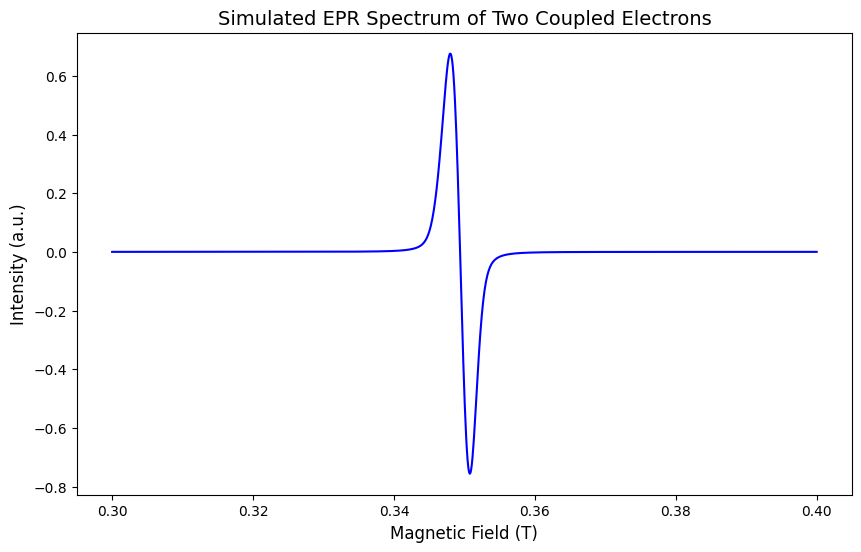

In [14]:
spectra_creator = spectra_manager.StationarySpectra(
    freq=9.8e9,    # Frequency in Hz
    sample=sample
)

# Define magnetic field range for simulation
fields = torch.linspace(0.30, 0.40, 1000)  # Field in Tesla

# Calculate spectrum
spectrum = spectra_creator(sample, fields)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(fields.numpy(), spectrum.numpy(), 'b-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum of Two Coupled Electrons', fontsize=14)
plt.show()

# 3. Additional settings

MarS supports some additional possibilities that can be usefull for many scenario

### 3.1 Save Created data

For statinary spectra for the many cases Mars supprots save sample and experemental parameters at different datatypes including .mat to open in EasySpin \

Let's save the spectra and check that spectra is similar to created in easyspin

In [18]:
# Let's save the sample parameters and experemental parameters
save_procedures.save(".\example.mat", sample=sample, spectra_creator=spectra_creator, field=fields, format_type="easyspin")

In [19]:
import pandas as pd

# Let's save the spectra itself
data_frame = pd.DataFrame({"field": fields, "spec": spectrum})
data_frame.to_csv(".\qulity_spectra.csv", header=False, index=False)

MarS supports print of a lot of different objects: interactions, spin systems, samples

### 3.2 Dtype and Device Settings in MarS

1) **Device Support:**
MarS is built on the PyTorch library and therefore supports flexible device configuration-most commonly cpu or cuda. By default, computations run on the CPU. However, you can explicitly set the device to cuda to accelerate computations, especially for time-resolved simulations, where GPU acceleration can provide speedups of 100–1000×.


2) **Floating-Point Precision:**
By default, MarS uses torch.float64 (double precision) for floating-point calculations. This is essential for accurately modeling systems with strong exchange interactions (e.g., >10 cm⁻¹) or large zero-field splitting parameters (D and E) for magnetic ions.
However, for systems with weaker interactions, double precision is often unnecessary. In such cases, using torch.float32 (single precision) is sufficient and can improve performance and memory efficiency.

In [20]:
device =  torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # set device cuda if it is possible
dtype = torch.float32

**Best Practice:**

For clarity and consistency, we recommend specifying both the device and dtype at the beginning of your workflow.
That said, like any standard torch.nn.Module, MarS objects support dynamic changes via the .to() method, allowing you to move tensors and parameters between devices or dtypes as needed.

In [21]:
sample = sample.to(device)
spectra_creator = spectra_creator.to(device)
fields = torch.linspace(0.30, 0.4, 1000, device=device)
spectrum = spectra_creator(sample, fields)

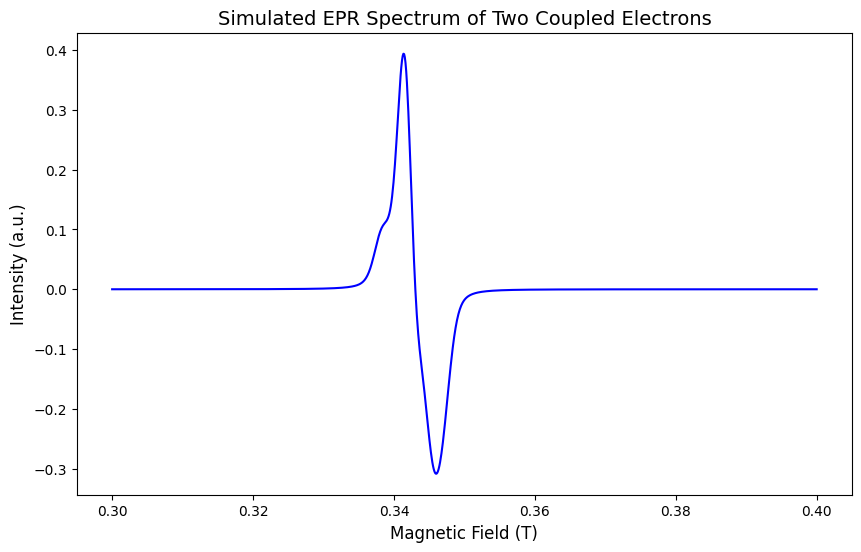

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(fields.to("cpu").numpy(), spectrum.to("cpu").numpy(), 'b-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum of Two Coupled Electrons', fontsize=14)
plt.show()

### 3.3 Batch Computing Support

MarS supports batched tensor inputs, enabling efficient parallel computation across multiple datasets.

This capability accelerates simulations when processing large collections of similar configurations

In [23]:
g_tensor = torch.tensor([[2.02, 2.04, 2.06], [2.04, 2.07, 2.09]], device=device, dtype=dtype)  # Two g-tensors set
g_tensor = spin_system.Interaction(components=g_tensor, device=device, dtype=dtype)

J = torch.tensor([[constants.unit_converter(1.0, "cm-1_to_Hz")], [constants.unit_converter(1.0, "cm-1_to_Hz")]])
exchange_interaction = spin_system.Interaction(J, device=device, dtype=dtype)

DE = torch.tensor([[100e6, 10e6], [200e6, 50e6]]) # D=100 MHz, E=10 MHz and D=200 MHz, E=50 MHz
dipolar_interaction = spin_system.DEInteraction(DE, device=device, dtype=dtype)  
total_interaction = exchange_interaction + dipolar_interaction

# Create the spin system with two electrons
base_spin_system = spin_system.SpinSystem(
    electrons=[0.5, 0.5],  # Two spin-1/2 electrons
    g_tensors=[g_tensor, g_tensor],  # g-tensor for each electron with the same g-tensors
    electron_electron=[(0, 1, total_interaction)],  # Interaction between electrons 0 and 1
    device=device, dtype=dtype
)

gauss=torch.tensor([0.001, 0.001]) # Gaussina broadening in Tesla: two values
lorentz=torch.tensor([0.001, 0.001])  # Lorentzian broadening in Tesla: two values

sample = spin_system.MultiOrientedSample(
    spin_system=base_spin_system, ham_strain=torch.tensor([[5e7, 5e7, 5e7], [5e7, 5e7, 5e7]]),
    lorentz=lorentz, gauss=gauss, device=device, dtype=dtype
)

spectra_creator = spectra_manager.StationarySpectra(
    freq=9.8e9,    # Frequency in Hz
    sample=sample
)

fields = torch.linspace(0.30, 0.4, 1000, device=device, dtype=dtype)
fields = torch.stack([fields, fields], dim=0)
spectrum = spectra_creator(sample, fields)

D:\ITC\РНФ_Курганский_2024\pythonProject\Mars\mars\spin_system.py:1122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  width = torch.tensor(width, device=device, dtype=dtype)


In [24]:
# Also for batched data the separate representation is determined
print(sample)

SPIN SYSTEM SUMMARY

PARTICLES:
--------------------
Electrons (2):
  e0: S=0.5 
BATCHED (batch_size=2) - showing first instance:
      Principal values: [2.0200, 2.0400, 2.0600]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None
  e1: S=0.5 
BATCHED (batch_size=2) - showing first instance:
      Principal values: [2.0200, 2.0400, 2.0600]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None

Nuclei: None

SYSTEM PROPERTIES:
--------------------
Hilbert space dimension: 4
Configuration shape: (2,)

INTERACTIONS (1 total):
------------------------------

Electron-Electron (1):
  1. e0 ↔ e1:
      BATCHED (batch_size=2) - showing first instance:
      Principal values: [3.00e+10, 2.99e+10, 3.00e+10]
      Frame (Euler angles): [α=0.000, β=0.000, γ=0.000] rad
      Strain: None


GENERAL INFO: 
BATCHED (batch_size=2) - showing first instance:
lorentz: 0.00100 T
gauss: 0.00100 T
ham_str (dim=torch.Size([3])): ['5.0000e+07', '5.0000e+07',

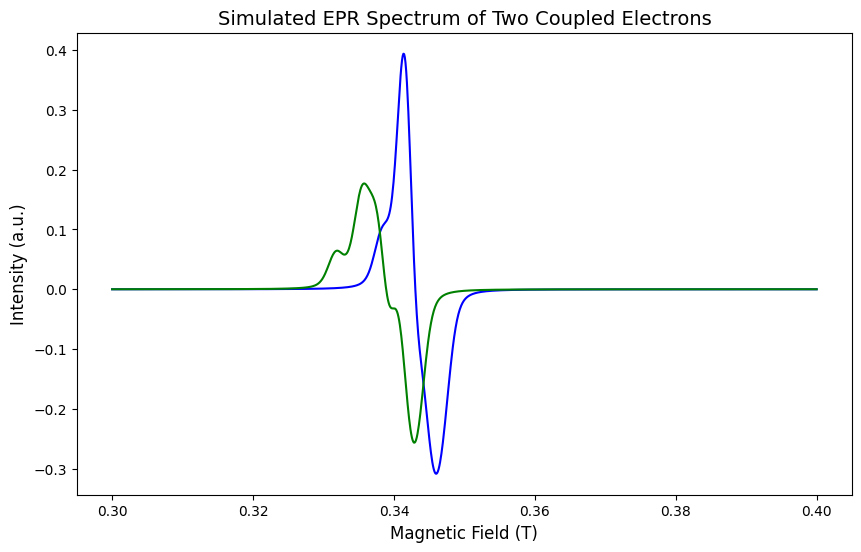

In [25]:
# Let's plot two spectra form a batch

plt.figure(figsize=(10, 6))
plt.plot(fields[0].to("cpu").numpy(), spectrum[0].to("cpu").numpy(), 'b-')
plt.plot(fields[1].to("cpu").numpy(), spectrum[1].to("cpu").numpy(), 'g-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum of Two Coupled Electrons', fontsize=14)
plt.show()

### 3.4. Different Mesh Configuration

By default, MarS uses the DelaunayMeshNeighbour mesh is a spherical mesh with neighborhood-based interpolation for powder samples. However, depending on the sample’s symmetry and structure, a different mesh type may be more appropriate:

-mesher.DelaunayMeshNeighbour: Designed for powder. It supports the phi_limits parameter to restrict the azimuthal angle range, which is useful when the sample -exhibits rotational symmetry.

-mesher.AxialMeshNeighbour: Designed for systems with axial (cylindrical) symmetry, where physical properties vary only with the polar angle and are invariant under rotation around a fixed axis.

-mesher.CrystalMesh: Designed for single-crystal or polycrystalline samples with defined orientations. In this case detection will be considered in x-axis direction

Let's return to out example with two spins and consider user-cases for this system and define function to work with mesh in more convinient way

In [26]:
import typing as tp

def create_spectrum_with_a_given_mesh(mesh: tp.Optional[tp.Union[mesher.BaseMesh, tuple[int, int]]]):
    """
    :param: mesh: the user-defined mesh to consider what types of mesh can be defined
    """
    g_tensor = spin_system.Interaction((2.02, 2.04, 2.06))
    
    exchange_interaction = spin_system.Interaction(
        constants.unit_converter(1.0, "cm-1_to_Hz")
    )
    dipolar_interaction = spin_system.DEInteraction([100e6, 10e6])
    total_interaction = exchange_interaction + dipolar_interaction
    
    base_spin_system = spin_system.SpinSystem(
        electrons=[0.5, 0.5],
        g_tensors=[g_tensor, g_tensor],
        electron_electron=[(0, 1, total_interaction)]
    )
    sample = spin_system.MultiOrientedSample(
        spin_system=base_spin_system,
        ham_strain=5e7,
        gauss=0.001,
        lorentz=0.001,
        mesh=mesh,  # add mesh here
        device=device,
        dtype=dtype
    )
    
    spectra_creator = spectra_manager.StationarySpectra(
    freq=9.8e9, sample=sample,
    device=device, dtype=dtype)
    
    fields = torch.linspace(0.30, 0.4, 1000, device=device, dtype=dtype)
    spectrum = spectra_creator(sample, fields)
    return fields.cpu().numpy(), spectrum.cpu().numpy()

Let's consider and plot samples with different meshesspectrum_crystal

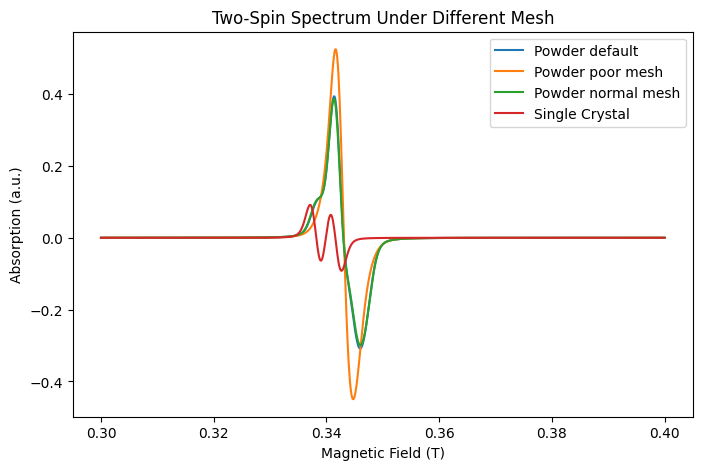

In [27]:
mesh_default = None
fields, spectrum_default = create_spectrum_with_a_given_mesh(mesh_default)

mesh_powder_as_tuple_poor = (4, 4)
mesh_powder_poor = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2 * np.pi),
                                    initial_grid_frequency=20,
                                    interpolate=False, device=device, dtype=dtype) # This is the same as mesh_powder_as_tuple_poor = (20, 20)
fields, spectrum_powder_poor = create_spectrum_with_a_given_mesh(mesh_powder_as_tuple_poor)

mesh_powder_as_tuple_normal = (40, 40)
mesh_powder_normal = mesher.DelaunayMeshNeighbour(phi_limits = (0, 2 * np.pi),
                                    initial_grid_frequency=40,
                                    interpolate=False, device=device, dtype=dtype)  # This is the same as mesh_powder_as_tuple_poor = (40, 40)
fields, spectrum_powder_normal = create_spectrum_with_a_given_mesh(mesh_powder_as_tuple_normal)


mesh_crystal = mesher.CrystalMesh(euler_angles=torch.tensor([0.0, 0.0, 0.0]), device=device, dtype=dtype) # CrystalMesh takes 3 euler angles (or set) of euler angles
fields, spectrum_crystal = create_spectrum_with_a_given_mesh(mesh_crystal)

plt.figure(figsize=(8, 5))
plt.plot(fields, spectrum_default, label="Powder default", linewidth=1.5)
plt.plot(fields, spectrum_powder_poor, label="Powder poor mesh", linewidth=1.5)
plt.plot(fields, spectrum_powder_normal, label="Powder normal mesh", linewidth=1.5)
plt.plot(fields, spectrum_crystal, label="Single Crystal", linewidth=1.5)
plt.xlabel("Magnetic Field (T)")
plt.ylabel("Absorption (a.u.)")
plt.title("Two-Spin Spectrum Under Different Mesh")
plt.legend()
plt.show()

As can be seen from the plot, the poor quality mesh produced poor results, which was expected.

# 4. Spectra Creation Examples

This section demonstrates practical applications of the Mars library for simulating EPR spectra of different spin systems.

#### 4.1 Two Coupled Electrons with Hyperfine Interactions to Nitrogen Nuclei

This example models a system of two dipolar-coupled electron spins (S = 1/2), where each electron interacts with a separate nitrogen-14 nucleus (I = 1) through anisotropic hyperfine coupling. Such systems are common in biradicals or coupled transition metal complexes with nitrogen ligands.

In [28]:
dtype = torch.float64
device =  torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # set device cuda if it is possible

# Define g-tensor for electrons
g_tensor = spin_system.Interaction((2.02, 2.04, 2.06), dtype=dtype, device=device)

# Define hyperfine coupling tensor for 14N nuclei (I=1)
# Values in Hz: Ax = 20 MHz, Ay = 20 MHz, Az = 70 MHz
A_interaction = spin_system.Interaction((20e6, 20e6, 70e6), dtype=dtype, device=device)  # 20 MHz, 20 MHz, 70 MHz

# Define Dipolar interaction
dipolar_interaction = spin_system.DEInteraction([100e6, 10e6])  # D=100 MHz, E=10 MHz

# Create the spin system with two electrons
base_spin_system = spin_system.SpinSystem(
    electrons=[0.5, 0.5],     # Two spin-1/2 electrons
    nuclei=["14N", "14N"],    # Two nitrogen-14 nuclei (I=1)
    g_tensors=[g_tensor, g_tensor],  # Identical g-tensors for both electrons
    electron_nuclei=[
        (0, 0, A_interaction),  # First electron coupled to first nitrogen
        (1, 1, A_interaction)   # Second electron coupled to second nitrogen
    ],
    electron_electron=[
        (0, 1, dipolar_interaction)  # Dipolar coupling between electrons
    ],
    dtype=dtype,
    device=device
)

sample = spin_system.MultiOrientedSample(
    spin_system=base_spin_system,
    ham_strain=1e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)

spectra_creator = spectra_manager.StationarySpectra(
freq=9.8e9, sample=sample,
device=device, dtype=dtype)

fields = torch.linspace(0.30, 0.4, 1000, device=device, dtype=dtype)
spectrum = spectra_creator(sample, fields)

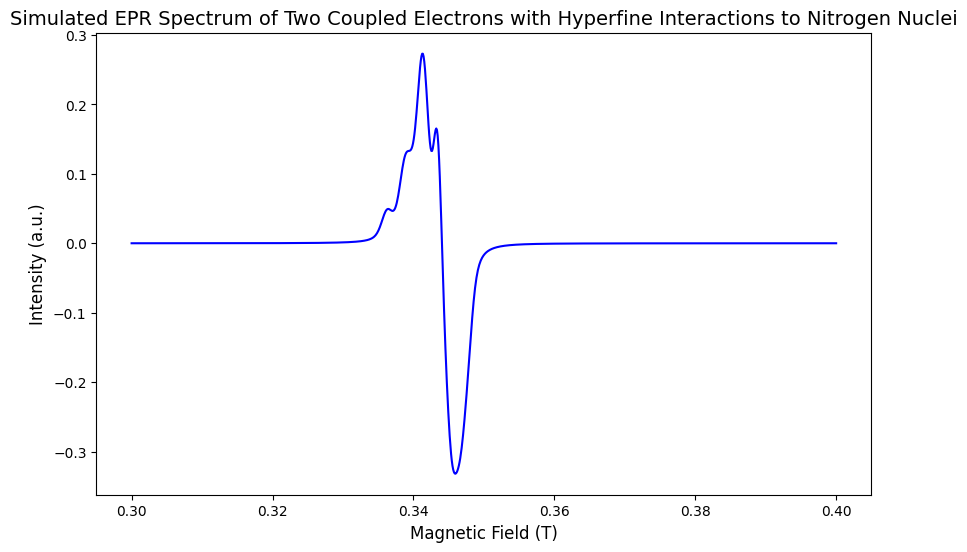

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(fields.to("cpu").numpy(), spectrum.to("cpu").numpy(), 'b-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum of Two Coupled Electrons with Hyperfine Interactions to Nitrogen Nuclei', fontsize=14)
plt.show()

#### 4.2 Manganese(II) Ion with Zero-Field Splitting at 4K Temperature

This example simulates the EPR spectrum of a manganese(II) ion (S = 5/2, I = 5/2 for ⁵⁵Mn) at liquid helium temperature (4 K). Mn(II) often shows complex spectra due to the combination of electron Zeeman, zero-field splitting, and hyperfine interactions.

In [30]:
dtype = torch.float64
device =  torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # set device cuda if it is possible

# Define anisotropic g-tensor for Mn(II) ion
g_tensor = spin_system.Interaction((2.02, 2.04, 2.12), dtype=dtype, device=device)

# Define isotropic hyperfine coupling for ⁵⁵Mn nucleus (I = 5/2)
# Magnitude is 300 MHz
A_interaction = spin_system.Interaction(300*1e6, dtype=dtype, device=device)  # 300 MHz, isotropic

# Define Zero Field splitting
zero_field_interaction = spin_system.DEInteraction([500e6, 100e6])  # D=500 MHz, E=100 MHz

# Create the spin system with two electrons
base_spin_system = spin_system.SpinSystem(
    electrons=[5/2],  # Single electron with S = 5/2
    nuclei = ["55Mn"], # ⁵⁵Mn nucleus with I = 5/2
    g_tensors=[g_tensor],  # g-tensor for the electron
    electron_nuclei=[(0, 0, A_interaction)], # Hyperfine coupling between electron and nucleus
    electron_electron=[(0, 0, zero_field_interaction)]  # Zero-Field parameter
)

sample = spin_system.MultiOrientedSample(
    spin_system=base_spin_system,
    ham_strain=5e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)

spectra_creator = spectra_manager.StationarySpectra(
freq=9.8e9, sample=sample, temperature=4.0,   # Set the temperature equel to 4 K
device=device, dtype=dtype)

fields = torch.linspace(0.2, 0.5, 1000, device=device, dtype=dtype)
spectrum = spectra_creator(sample, fields)

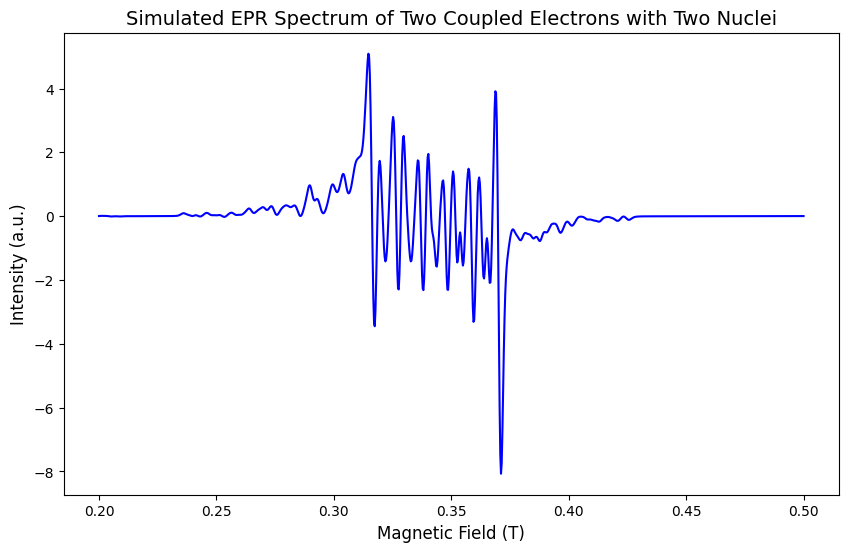

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(fields.to("cpu").numpy(), spectrum.to("cpu").numpy(), 'b-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Simulated EPR Spectrum of Two Coupled Electrons with Two Nuclei', fontsize=14)
plt.show()

#### 4.3 Exchange-Coupled High-Spin Ions with Rotated g-Tensors at 4 K temperature 

This example demonstrates the simulation of two exchange-coupled S = 1 ions where one ion has a rotated g-tensor relative to the other ion g-tensor. Exchange coupling between high-spin ions is common in binuclear transition metal complexes. The rotation of one ion's g-tensor simulates a scenario where the local symmetry axes of the two metal centers are misaligned.

In [87]:
dtype = torch.float64
device =  torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # set device cuda if it is possible

# Define g-tensor for electrons
#First ion: Standard orientation with orthorhombic g-tensor
g_tensor_first = spin_system.Interaction((2.02, 2.07, 2.20), dtype=dtype, device=device)

# Second ion: Same principal values but rotated by Euler angles (α=0.0, β=0.1, γ=0.7 radians)
# This simulates a physical rotation of the ion's local coordinate system
g_tensor_second = spin_system.Interaction((2.02, 2.07, 2.20), frame=[0.0, 0.7, 0.0], dtype=dtype, device=device)


# Define isotropic exchange interaction between the two ions
exachange_interaction = spin_system.Interaction(constants.unit_converter(-1, "cm-1_to_Hz"))  # 1 cm^-1

# Create the spin system with two electrons
base_spin_system = spin_system.SpinSystem(
    electrons=[1.0, 1.0],  # Two spin-1 systems
    g_tensors=[g_tensor_first, g_tensor_second],  # Different orientations for each ion
    electron_electron=[(0, 0, exachange_interaction)]  # Exchange coupling between ion 0 and ion 1
)

sample = spin_system.MultiOrientedSample(
    spin_system=base_spin_system,
    ham_strain=7e7,
    gauss=0.001,
    lorentz=0.001,
    device=device,
    dtype=dtype
)

spectra_creator = spectra_manager.StationarySpectra(
freq=9.8e9, sample=sample, temperature=4.0,   # Set the temperature equel to 4 K
device=device, dtype=dtype)

fields = torch.linspace(0.3, 0.4, 1000, device=device, dtype=dtype)
spectrum = spectra_creator(sample, fields)

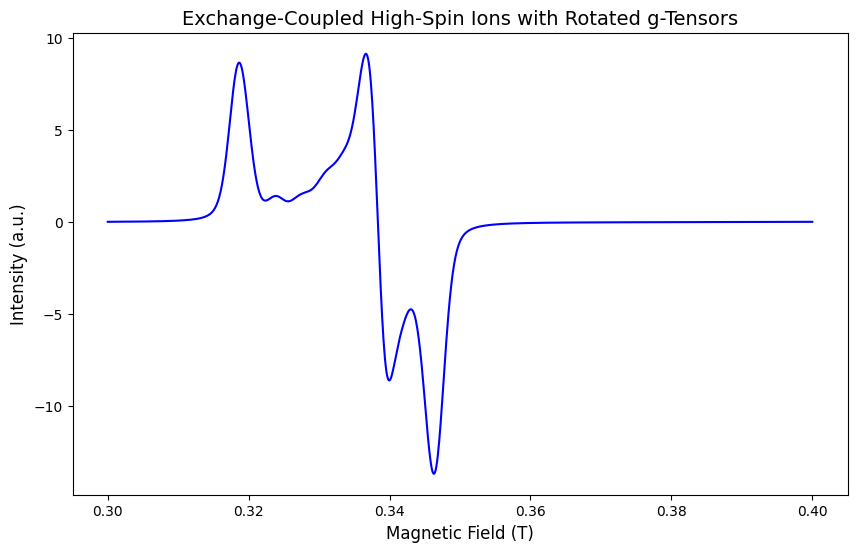

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(fields.to("cpu").numpy(), spectrum.to("cpu").numpy(), 'b-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Exchange-Coupled High-Spin Ions with Rotated g-Tensors', fontsize=14)
plt.show()

#### 4.4 Strain Broadening Example

Spectral broadening in EPR spectroscopy arises from various mechanisms, with Hamiltonian parameters strain being particularly important for disordered systems like powders, frozen solutions, or amorphous solids. Hamiltonian parameters strain refers to the distribution of spin Hamiltonian parameters (g-values, zero-field splitting parameters, hyperfine couplings) due to structural variations in the sample environment.

This example demonstrates how to model a high-spin system (S = 3/2) with explicit strain distributions in its zero-field splitting parameters. 

In [60]:
dtype = torch.float64
device =  torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # set device cuda if it is possible

# Define g-tensor for the S=3/2 ion
g_tensor = spin_system.Interaction((2.02, 2.07, 2.10), dtype=dtype, device=device)

# Define zero-field splitting interaction with explicit strain parameters
# D = 500 MHz (axial parameter), E = 100 MHz (rhombic parameter)
# Strain values: 50 MHz for D-parameter distribution, 10 MHz for E-parameter distribution
zero_field_interaction = spin_system.DEInteraction([500e6, 100e6], strain=[200e6, 40e6], dtype=dtype, device=device)  


# Create the spin system with one electron
base_spin_system = spin_system.SpinSystem(
    electrons=[3/2],  # Two spins of 1.0
    g_tensors=[g_tensor],  # g-tensor for an electron spin
    electron_electron=[(0, 0, zero_field_interaction)],  # Zero-field splitting interaction
    dtype=dtype, device=device
)

sample = spin_system.MultiOrientedSample(
    spin_system=base_spin_system,
    ham_strain=0e7,
    gauss=0.000,
    lorentz=0.001,
    device=device,
    dtype=dtype,
    mesh = (60, 60)
)

spectra_creator = spectra_manager.StationarySpectra(
freq=9.8e9, sample=sample, temperature=4.0,   # Set the temperature equel to 4 K
device=device, dtype=dtype)

fields = torch.linspace(0.25, 0.45, 1000, device=device, dtype=dtype)
spectrum = spectra_creator(sample, fields)

torch.Size([1830, 2, 3])
tensor([3.1510e+15, 3.1537e+15, 3.5246e+06], dtype=torch.float64)


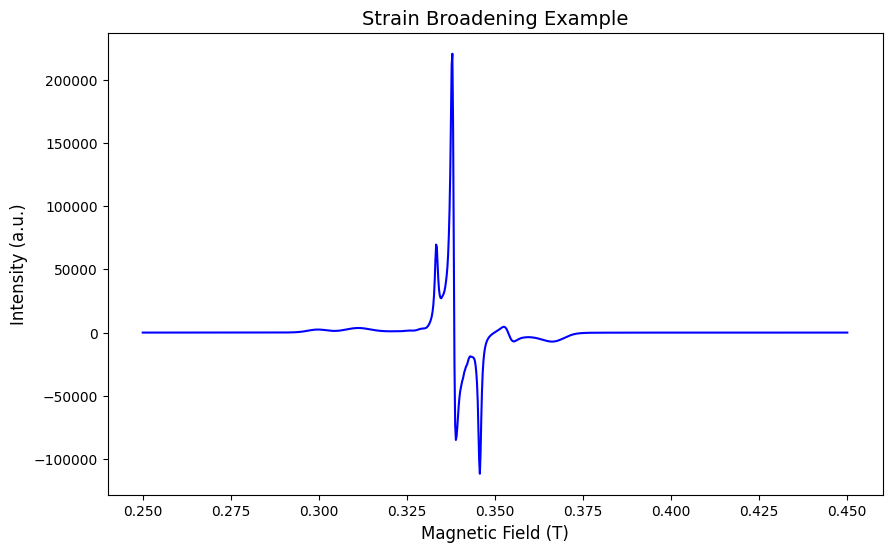

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(fields.to("cpu").numpy(), spectrum.to("cpu").numpy(), 'b-')
plt.xlabel('Magnetic Field (T)', fontsize=12)
plt.ylabel('Intensity (a.u.)', fontsize=12)
plt.title('Strain Broadening Example', fontsize=14)
plt.show()

In [42]:
save_procedures.save(".\example.mat", sample=sample, spectra_creator=spectra_creator, field=fields, format_type="easyspin")

In [43]:
import pandas as pd

# Let's save the spectra itself
data_frame = pd.DataFrame({"field": fields, "spec": spectrum})
data_frame.to_csv(".\qulity_spectra.csv", header=False, index=False)